In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

music = pd.DataFrame()
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]
music['bpm'] = [ 105, 90, 78, 75, 120, 110, 80, 100, 105, 60,
                  70, 105, 95, 70, 90, 105, 70, 75, 102, 100,
                  100, 95, 90, 80, 90, 80, 100, 105, 70, 65]

# KNN Regression

So far we've introduced KNN as a classifier, meaning it assigns observations to categories or assigns probabilities to the various categories. However, KNN is also a reasonable algorithm for regression. It's a simple extension of what we've learned before and just as easy to implement.

## Everything's the Same

Switching KNN to a regrssion is a simple process. In our previous models, each of the $k$ oberservations voted for a _category_. As a regression they vote instead for a _value_. Then instead of taking the most popular response, the algorithm averages all of the votes. If you have weights you perform a weighted average.

It's really that simple.

Let's go over a quick example just to confirm your understanding.

Let's stick with the world of music. Instead of trying to classify songs as rock or jazz, lets take the same data with an additional column: beats per minute, or BPM. Can we train our model to predict BPM?

First let's try to predict just in terms of loudness, as this will be easier to represent graphically.

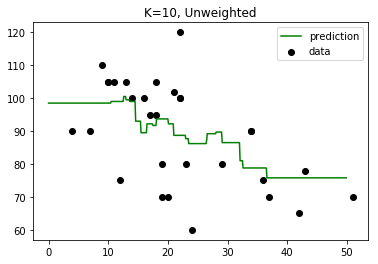

In [2]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

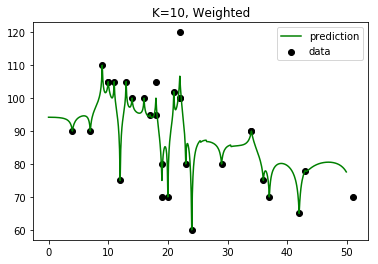

In [52]:
# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn_w.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Weighted')
plt.show()

Notice how it seems like the weighted model grossly overfits to points. It is interesting that it oscillates around the datapoints. This is because the decay in weight happens so quickly.


## Validating KNN

Now validating KNN, whether a regression or a classifier, is pretty much exactly the same as evaluating other classifiers or regression. Cross validation is still tremendously valuable. You can do holdouts. You even still get an $R^2$ value for the regression.

Why don't we validate that overfitting of the previous model with some k-fold cross validation? The test statistic given by this model is $R^2$, which measures the same as in linear regression.

In [4]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.18 (+/- 0.66)
Weighted Accuracy: 0.11 (+/- 0.94)


First let me state that these two models are fantastically awful. There doesn't seem to be much of a relationship. It's all very poor. However the increased variance in the weighted model is interesting.

Why don't you add the other feature and mess around with $k$ and weighting to see if you can do any better than we've done so far?

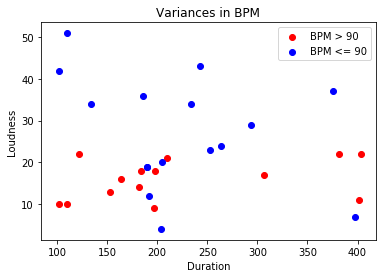

In [70]:
## Your model here.

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=4)
X = music[['loudness', 'duration']]
Y = music.bpm
knn.fit(X, Y)

# Set up our prediction line.
# Loudness ranges from 18 to 42, so 0 to 50 is ok
T_loudness = np.random.randint(0, 50, 100)
T_loudness.sort()
# Duration ranges from around 100 to around 410
T_duration = np.random.randint(100, 410, 100)
T_duration.sort()
T = [(l,d) for l,d in zip(T_loudness, T_duration)]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(
    music[music['bpm'] > 90].duration,
    music[music['bpm'] > 90].loudness,
    color='red'
)
plt.scatter(
    music[music['bpm'] <= 90].duration,
    music[music['bpm'] <= 90].loudness,
    color='blue'
)


plt.legend(['BPM > 90', 'BPM <= 90'])
plt.title('Variances in BPM')
plt.xlabel('Duration')
plt.ylabel('Loudness')
plt.show()

In [71]:
# Search for an optimal number of neighbors for KNN, then change the value above
k_range = range(1,20)
k_scores = []
for k in k_range:
    knn_w = neighbors.KNeighborsRegressor(n_neighbors = k, weights = 'distance')
    scores = cross_val_score(knn_w, X, Y, cv = 10)
    k_scores.append(scores.mean())
print(k_scores)

[-42.009632357398424, -24.083515557972696, -14.741627434489772, -13.851145116675557, -16.536028273803971, -18.009681902765401, -20.407317926950554, -17.28217741580761, -16.798144259406108, -17.571977881437139, -17.294797745850879, -17.619432320803913, -16.936645525930082, -17.35875307709188, -16.653769987802175, -16.928745975442901, -17.629017036079563, -17.112692057659501, -16.976793558585289]


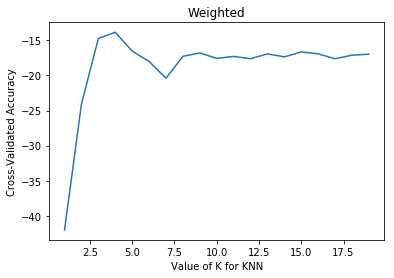

The optimal value for k (weighted by distance) = k=4


In [72]:
# Plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title("Weighted")
plt.show()

print('The optimal value for k (weighted by distance) = k={}'.format(k_scores.index(max(k_scores))+1))

The plot shows that a low loudness and duration more strongly corresponds to a BPM <= 90.
Also, the plot shows that loudness has a greater affect on BPM. 

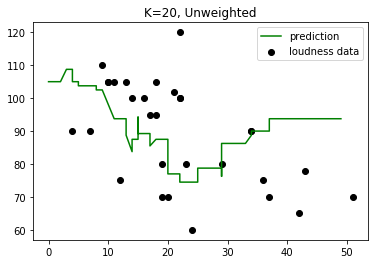

In [73]:
plt.scatter(X.loudness, Y, c='k', label='loudness data')
plt.plot(T_loudness, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=20, Unweighted')
plt.show()

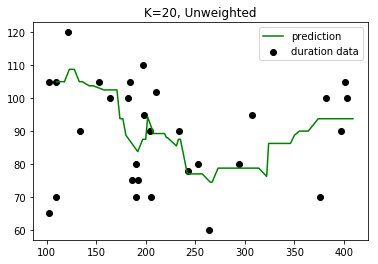

In [74]:
plt.scatter(X.duration, Y, c='k', label='duration data')
plt.plot(T_duration, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=20, Unweighted')
plt.show()

Still doesn't look great. Let's try adding weight.

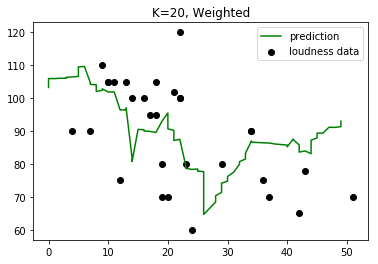

In [79]:
# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=4, weights='distance')
X = music[['loudness', 'duration']]
Y = music.bpm
knn_w.fit(X, Y)

# Set up our prediction line.
# Loudness ranges from 18 to 42, so 0 to 50 is ok
T_w_loudness = np.random.randint(0, 50, 100)
T_w_loudness.sort()
# Duration ranges from around 100 to around 410
T_w_duration = np.random.randint(100, 410, 100)
T_w_duration.sort()
T = [(l,d) for l,d in zip(T_w_loudness, T_w_duration)]

# Trailing underscores are a common convention for a prediction.
Y_w = knn_w.predict(T)

plt.scatter(X.loudness, Y, c='k', label='loudness data')
plt.plot(T_w_loudness, Y_w, c='g', label='prediction')
plt.legend()
plt.title('K=20, Weighted')
plt.show()

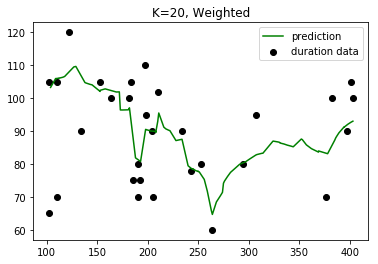

In [80]:
plt.scatter(X.duration, Y, c='k', label='duration data')
plt.plot(T_w_duration, Y_w, c='g', label='prediction')
plt.legend()
plt.title('K=20, Weighted')
plt.show()

In [81]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.84 (+/- 1.25)
Weighted Accuracy: -0.63 (+/- 1.64)


This model is worse than the previous comparisons of the assignment (listed below). It would be helpful if we had a larger dataset to pull from. 

Unweighted Accuracy: -0.18 (+/- 0.66)
Weighted Accuracy: 0.11 (+/- 0.94)